In [71]:
import numpy as np
import jax.numpy as jnp
import re
import cupy as cp
import pickle
import time
import numpy as np
import jax.numpy as jnp
import pandas as pd
import numpy as np
import jax
import spacy
from tqdm import tqdm
from pathlib import Path
import json

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))


def log_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)  # Execute the wrapped function
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time
        # print(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result

    return wrapper
class Helper: 
    
    def get_positional_encoding(self,seq_len, d_model):
        """
        Returns a non-learnable (sinusoidal) positional encoding.


        seq_len: Length of the input sequence.
        d_model: Dimension of the embeddings.
        """
        pos = cp.arange(seq_len)[:, cp.newaxis]  # Shape: [seq_len, 1]
        i = cp.arange(d_model)[cp.newaxis, :]  # Shape: [1, d_model]

        angle_rates = 1 / cp.power(10000, (2 * (i // 2)) / cp.float32(d_model))

        # Apply sine to even indices, cosine to odd indices
        pos_encoding = cp.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = cp.sin(pos * angle_rates[:, 0::2])  # sine on even indices
        pos_encoding[:, 1::2] = cp.cos(pos * angle_rates[:, 1::2])  # cosine on odd indices

        return pos_encoding


    def softmax(self,x):
        # Subtract the max value for numerical stability
        max_logits = cp.max(x, axis=-1, keepdims=True)
        exp_logits = cp.exp(x - max_logits)
        return exp_logits / cp.sum(exp_logits, axis=-1, keepdims=True)

 
    # @log_time
    def pad_sequence(self,seq, max_len, pad_value=0):
        """Pad a sequence with a given value up to max_len."""
        current_len = seq.shape[0]
        pad_width = max_len - current_len
        if pad_width > 0:
            # Pad sequence with zeros (or any pad_value you provide)
            seq = cp.pad(seq, ((0, pad_width), (0, 0)), mode='constant', constant_values=pad_value)
        return seq


    @log_time
    def create_timestaped_input(self,input_d, words_per_phrase):
        input_translation = []
        for j in range(input_d.shape[0]):
            # Create padded sequences
            padded_sequences = [self.pad_sequence(input_d[j][0:i], words_per_phrase) for i in range(1, input_d.shape[1] + 1)]
            input_translation.append(padded_sequences)
        return cp.array(input_translation)


    def cross_entropy_loss(self,predictions, targets):
        epsilon = 1e-12  # Small constant to avoid log(0)
        predictions = cp.clip(predictions, epsilon, 1 - epsilon)  # Clipping predictions
        return -cp.sum(targets * cp.log(predictions), axis=1).mean()



 
    def redimension(self,X):
        return cp.concatenate(cp.swapaxes(X, 0, 1), axis=-1)
    
    @log_time
    def create_vocabulary(self,complete_text, name, nlp):
        # Use re.findall to split considering punctuation
        text = re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', complete_text)

        words_list = list(set(text))

        vocabulary = dict()

        for i, j in enumerate(words_list):
            # vocabulary[j]=(jax.random.uniform(jax.random.key(cp.random.randint(10000)),embedding_size),i)
            vocabulary[j] = (cp.array(nlp(j).vector), i)
            # print(j,len(cp.array(nlp(j).vector)))

        # print(vocabulary)
        # print("Vocabulary size: ", len(vocabulary))
        with open(f"data/{name}.pkl", 'wb') as handle:
            pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return vocabulary


    @log_time
    def pad_sequences(self,sentences, lenght, pad_token='[PAD]', target_type=None):
        """
        Pads the input sentences to have the same length by adding [PAD] tokens at the end.
        """

        if target_type == "encoder":
            # Split each sentence into words
            tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]\n', sentence) + ["[END]"] for sentence in
                                sentences]
        elif target_type == "decoder":
            tokenized_sentences = [["[START]"] + re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) for sentence in sentences]
        elif target_type == "target":
            tokenized_sentences = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', sentence) + ["[END]"] for sentence in sentences]
        # print(tokenized_sentences)
        if lenght == 0:
            # Find the maximum sentence length
            max_len = max(len(sentence) for sentence in tokenized_sentences)
        else:
            max_len = lenght

        # Pad each sentence with the [PAD] token to make them of equal length
        padded_sentences = [" ".join(sentence + [pad_token] * (max_len - len(sentence))) for sentence in
                            tokenized_sentences]

        return padded_sentences

    def print_matrix(self,X):
        for i in X:
            print(i)

    @log_time
    def generate_input_encoder(self,x_batch, vocabulary_encoder, max_words_per_phrase):

        x_train = self.pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")# here are string
        
        #print_matrix(x_train) 
    
        xi = []
        # print(x_batch)
        phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]
        #print_matrix(phrase_vectors_x) 
        phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]

        # print(phrase_vectors_x)
        # a=cp.array(phrase_vectors_x).shape

        # print("a",a)
        # print("len phrases:\n",[len(i) for i in phrase_vectors_x])

        xi = cp.array([[vocabulary_encoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_x])

        return xi


    # @log_time
    def update_wembedding_encoder(self,x_batch, inputs_e, vocabulary, max_words_per_phrase):
        x_train = self.pad_sequences(x_batch, max_words_per_phrase, target_type="encoder")
        # print(x_train)

        phrase_vectors_x = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in x_train]

        phrase_vectors_x = [i[0:max_words_per_phrase] for i in phrase_vectors_x]
        # print("inputs_e",inputs_e.shape)
        # print("(phrase_vectors_x).shape:\n",cp.array(phrase_vectors_x).shape)

        for phrase in range(inputs_e.shape[0]):
            # print(phrase)
            for position, word in enumerate(phrase_vectors_x[phrase]):
                #   print("word",word)
                #   print("original values",vocabulary[word][0])
                #   print("updated  values",inputs_e[phrase][position])
                #   print("index",vocabulary[word][1])
                vocabulary[word] = (inputs_e[phrase][position], vocabulary[word][1])

        return vocabulary


    # @log_time
    def update_wembedding_decoder(self,y_batch, inputs_decoder, max_words_per_phrase, vocabulary):
        # print("inputs_decoder",inputs_decoder.shape)
        decoder_input = self.pad_sequences(y_batch, lenght=max_words_per_phrase, target_type="decoder")
        decoder_input = [i.split() for i in decoder_input]
        # print(max_words_per_phrase)
        if max_words_per_phrase == None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
        # for sentence in phrase_vectors_y:
        #     print(sentence)
        for phrase in range(inputs_decoder.shape[0]):
            # print(phrase)
            for position, word in enumerate(phrase_vectors_y[phrase]):
                # print("word",word)
                # print("original values",vocabulary[word][0])
                # print("updated  values",inputs_decoder[phrase][position])
                #  print("delta input",cp.sum(vocabulary[word][0]-inputs_decoder[phrase][position]))
                # print("index",vocabulary[word][1])
                vocabulary[word] = (inputs_decoder[phrase][position], vocabulary[word][1])

        return vocabulary


    @log_time
    def create_input_encoder(self,X, vocabulary_encoder, max_words_per_phrase, embedding_size):

        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        #print(pos_encoding)
        inputs_e = self.generate_input_encoder(X, vocabulary_encoder, max_words_per_phrase)
        
        #print(inputs_e)

        inputs_e += pos_encoding
        return inputs_e


    @log_time
    def create_decoder_input(self,y_train, embedding_size, max_words_per_phrase, vocabulary_decoder):
        decoder_input = self.pad_sequences(y_train, lenght=max_words_per_phrase, target_type="decoder")
        #print_matrix(decoder_input)
        decoder_input = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', i) for i in decoder_input]
        
        if max_words_per_phrase == None:
            max_words_per_phrase = len(decoder_input[0])

        phrase_vectors_y = [i[0:max_words_per_phrase] for i in decoder_input]
        # for sentence in phrase_vectors_y:
        #     print(sentence)
        #print_matrix(phrase_vectors_y)
        

        yi = cp.array([[vocabulary_decoder[word][0] for word in phrase_vector] for phrase_vector in phrase_vectors_y])
        
        pos_encoding = self.get_positional_encoding(max_words_per_phrase, embedding_size)
        # print(pos_encoding.shape,yi.shape)
        yi = yi + pos_encoding
        #print_matrix(yi)
        decoder_inputs = cp.array(cp.swapaxes(self.create_timestaped_input(yi, max_words_per_phrase), 0, 1))
        
        # decoder_inputs[zero_rows] = vocabulary_decoder["[PAD]"][0]
        for i in range(decoder_inputs.shape[0]):
            for j in range(decoder_inputs[i].shape[0]):
                zero_rows = cp.all(decoder_inputs[i][j] == 0, axis=1)

                decoder_inputs[i][j][zero_rows] = vocabulary_decoder["[PAD]"][0]

        decoder_inputs = cp.array(decoder_inputs)
        #print(decoder_inputs[2])
        #print(decoder_inputs)
        return decoder_inputs

    # @log_time
    def get_one_hot(self,word, vocabulary_decoder):
        # print(word)
        vocab_size = len(vocabulary_decoder)
        one_hot_vector = cp.zeros(vocab_size)
        one_hot_vector[vocabulary_decoder[word][1]] = 1
        # print(vocabulary_decoder[word][1])
        # print(np.where(one_hot_vector== 1))
        # print(cp.sum(one_hot_vector))
        return one_hot_vector
 
    def print_vocabs(self,ans, vocabulary,yy,step,target,counter_correct):
        
        #print("----DECODER-----")
        print("target",target)
        print("ans",ans)
        # yy=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in yy] 
        
        # for idx, values in enumerate(ans):
        #     max_index = cp.argmax(values)
            
        #     # Step 2: Find the word in the vocabulary with the corresponding position
        #     predicted_word = None
        #     for word, (_, position) in vocabulary.items():
        #         if position == max_index:
        #             predicted_word = word
                 
        #             if max_index==position:
        #                 print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {matched_word}")
                         
        #             break
        #     #print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {matched_word}")
        # #print()
    #def print_
    def log_sparse_entropy(self,ans,target,y_batch,step):
        #print("target",target)
        #print("ans",ans)
        counter_found=0
        total_lenght=len(ans)
        print(f"----DECODER--step {step}---")
        self.print_matrix(y_batch)
        print("target",target)
        indexes=[]
        yy=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in y_batch] 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values)
            indexes.append(max_index)
             
            if max_index==target[idx]:
                counter_found+=1
            print(f"{idx + 1} base: {' '.join(yy[idx][0:step+1])} -> {max_index}")
        print("indexes",indexes)
        print("accuracy batch:",round(counter_found/total_lenght,2))
        
    def accruacy_sparse_entropy(self,ans,target):
        counter_found=0
        total_lenght=len(ans) 
        for idx, values in enumerate(ans):
            max_index = cp.argmax(values) 
            if max_index==target[idx]:
                counter_found+=1
             
        accuracy_batch_on_step=round(counter_found/total_lenght,2)
        return accuracy_batch_on_step
    

    def print_target_vs_prediction_sparce_loss(self,ans,target):
        
         
        indexes=[]
       
        for idx, values in enumerate(ans):
            max_index = np.argmax(values).item()
            indexes.append(max_index)
             
        print("target",target)
        print("indexes",indexes)
        


    
    def sparse_categorical_crossentropy(self,probabilities, labels):
        """
        Compute sparse categorical cross-entropy loss for next token prediction.
        
        Args:
            logits: Numpy array of shape (batch_size, num_classes), raw model outputs.
            labels: Numpy array of shape (batch_size,), integer-encoded labels of the next tokens.

        Returns:
            Scalar: The average cross-entropy loss across the batch.
        """
        # Step 1: Apply softmax to logits to get probabilities
        

        # Step 2: Extract probabilities for the correct class (target labels)
        batch_size = probabilities.shape[0]
        correct_class_probs = probabilities[np.arange(batch_size), labels]

        # Step 3: Compute the log of probabilities and then the negative log-likelihood
        loss = -np.log(correct_class_probs + 1e-8)  # Add small epsilon for numerical stability

        # Step 4: Return the average loss across the batch
        return np.mean(loss)
    
    

class layer_dropout: 
    def __init__(self,dropout_rate=0.1):
        self.dropout_rate=dropout_rate 
    def forward(self,X, training=True):  
        
        mask = cp.random.rand(*X.shape) > self.dropout_rate 
        result = X * mask 
        return result

class layer_normalization: 
    def __init__(self,epsilon=1e-6):
        self.epsilon=epsilon
        self.mu=0
        self.var=0
        self.N=0
          

    def forward(self,x):
        self.X=x
        self.N=x.shape[-1]
        self.alpha = cp.ones(self.N)
        self.bias = cp.zeros(self.N)
        self.mu = cp.mean(x, axis=-1, keepdims=True)
        self.std = cp.var(x, axis=-1, keepdims=True)  
        x_norm = self.alpha*(x - self.mu)/cp.sqrt(self.var + self.epsilon) +self.bias
        return x_norm
    
    def compute_derivative_A(self,X, mu,sqrVar,sqrVar_3_2):
        A=1 /sqrVar
        B=X*(X-mu)
        result=A-(B/sqrVar_3_2)
        return result
    
    def compute_derivative_B(self,X, mu,sqrVar,N,sqrVar_3_2):
        A=-1/(N*sqrVar)
        B=mu*(X-mu)
        result=A+(B/sqrVar_3_2)
        return result
    
    def backpropagation(self):
        sqrVar=cp.sqrt(self.var+self.epsilon)
        sqrVar_3_2=self.N*((self.var + self.epsilon) ** (3 / 2)) 
        A=self.compute_derivative_A(self.X, self.mu, sqrVar,sqrVar_3_2)
        B=self.compute_derivative_B(self.X, self.mu,sqrVar,self.N,sqrVar_3_2)
        result=A+B
        return result

class linear_layer: 
    def __init__(self,input_size,output_size,out=False,only_weights=False):
        if out==True:
            self.W=cp.random.rand(input_size, output_size)/cp.sqrt(input_size)
        else:
            self.W=cp.random.rand(input_size, output_size)
        if only_weights==True:
            pass
        else: 
            self.b=cp.random.rand(output_size)
      
    def forward(self,X): 
        self.X=X
        Xout = cp.matmul(X, self.W) + self.b 
        return Xout
    
    def forward_weights_only(self,X): 
        self.X=X
        Xout = cp.matmul(X, self.W) 
        return Xout
     
    
    def update_weights(self,dLoss_dW,dLoss_db,learning_rate):
        self.W=self.W-learning_rate*dLoss_dW
        self.b=self.b-learning_rate*dLoss_db

    def update_weights_only(self,dLoss_dW,learning_rate):
        self.W=self.W-learning_rate*dLoss_dW
       
class fully_connected_block:
    def __init__(self,embedding_size,hidden_size):
        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.linear_layer_1=linear_layer(self.embedding_size,self.hidden_size)
        self.linear_layer_2=linear_layer(self.hidden_size,self.embedding_size)
        self.dropout=layer_dropout()
        self.ReLu=ReLu_layer()

    def forward(self,x):
        x_1=self.dropout.forward(self.ReLu.forward_leaky(self.linear_layer_1.forward(x)))
        x_2=self.linear_layer_2.forward(x_1)
        return x_2
    

 
class ReLu_layer:
    def __init__(self,alpha=0.01):
        self.alpha=alpha 
    def forward_leaky(self,X):
        self.X=X
        return cp.where(X > 0, X, self.alpha * X)

    def forward(self,X): 
        self.X=X
        return cp.maximum(0,self.X)
    
    def backward(self, dLoss): 
        # Gradient of ReLU is 1 for x > 0, else 0
        dx = dLoss * (self.X > 0)  # Only propagate gradients for inputs > 0
        return dx
    
    def backward_leaky(self, dLoss): 
        dx = dLoss * cp.where(self.X > 0, 1, self.alpha)  # Gradient: 1 for x > 0, else alpha
        return dx

class residual_layer:
    def __init__(self):
        self.dropuot=layer_dropout()
        self.normalization=layer_normalization()


    def forward(self,x,sublayer_output):
        result=self.dropuot.forward(self.normalization.forward(x+sublayer_output))
        return result


      
class multihead_attention: 
    def __init__(self,embedding_size,num_heads,batch_size):
        self.num_heads=num_heads
        self.dk=embedding_size//num_heads
        self.batch_size=batch_size
        self.embedding_size=embedding_size
        self.q=linear_layer(self.embedding_size,self.embedding_size,only_weights=True)
        self.k=linear_layer(self.embedding_size,self.embedding_size,only_weights=True)
        self.v=linear_layer(self.embedding_size,self.embedding_size,only_weights=True)
        self.WO=linear_layer(self.embedding_size,self.embedding_size,only_weights=True)
        self.dropout=layer_dropout()
        self.helper=Helper()
        
    def reshape_heads(self,Q,K,V):
        self.Q = cp.swapaxes(cp.array(np.array_split(Q, self.num_heads, axis=2)), 0, 1)
        # print("Qval.shape: ",Q_E.shape)
        self.K = cp.swapaxes(cp.array(np.array_split(K, self.num_heads, axis=2)), 0, 1)
        # print("Kval.shape: ",K_E.shape)
        self.V = cp.swapaxes(cp.array(np.array_split(V, self.num_heads, axis=2)), 0, 1)
        #return self.Q,self.K,self.V

    def QKV(self,input_q,input_k,input_v): 
        Q=self.q.forward_weights_only(input_q)
        K=self.k.forward_weights_only(input_k)
        V=self.v.forward_weights_only(input_v) 
        self.reshape_heads(Q,K,V)
        

    def attention_weights(self): 
        QKscaled =cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])  
        self.Attention_weights = self.helper.softmax(QKscaled)
         

    def forward_attention(self,input_q,input_k,input_v): 
        self.QKV(input_q,input_k,input_v)
        self.attention_weights()
        Attention = cp.matmul(self.Attention_weights, self.V)
        # print("Attention shape:",Ae.shape)
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)])
        #print("Attention encoder shape concat:",Attention.shape)
        #print("Attention encoder shape concat:",self.WO.W.shape)
        Output=self.dropout.forward(cp.matmul(Attention,self.WO.W))
        print("Output encoder shape concat:",Output.shape)
        return Output
    
    def forward_masked_attention(self,input_q,input_k,input_v,mask_size):
        self.QKV(input_q,input_k,input_v)
        self.attention_weights_masked(mask_size)
        Attention = cp.matmul(self.Attention_weights, self.V)
        # print("Attention shape:",Ae.shape)
        Attention = cp.array([cp.concatenate(Attention[i], axis=1) for i in range(self.batch_size)])
        # print("Attention encoder shape concat:",Ae.shape)
        Output=self.dropout.forward(cp.matmul(Attention,self.WO.W))
        return Output
    
    def attention_weights_masked(self,mask_size):
        #mask_size =  words_per_phrase 

        QKscaled = cp.matmul(self.Q, cp.transpose(self.K, (0, 1, 3, 2))) / cp.sqrt(self.K.shape[-1])
        mask = cp.tril(cp.ones((mask_size, mask_size)))  # (9, 9) lower triangular matrix
        mask[mask == 0]=-cp.inf  # Set future tokens to -inf
        mask[mask == 1]=0  # Set allowed tokens to 0
        mask = mask.reshape(1, 1, mask_size, mask_size)
        QKscaled = QKscaled + mask
        self.Attention_weights = self.helper.softmax(QKscaled)
         
    
    def diffQi(self,dAttention,X):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_dX=cp.transpose(dAttention, (0, 2, 1)) @ (self.helper.redimension(dAttention_weights @ (self.K * self.V) / cp.sqrt(self.K.shape[-1]))*X)
        return cp.sum(dLoss_dX,axis=0)
    
    def diffKi(self,dAttention,X):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        X = cp.swapaxes(cp.array(cp.array_split(X, self.num_heads, axis=2)), 0, 1) 
         
        dLoss_dX = cp.transpose(dAttention, (0, 2, 1)) @ self.helper.redimension(
            (dAttention_weights * (self.Q @ cp.transpose(self.V, (0, 1, 3, 2))) @ X) / cp.sqrt(self.K.shape[-1])) 
        return cp.sum(dLoss_dX,axis=0)
    
    def diffVi(self,dAttention,X):
        dLoss_Vc = cp.sum(cp.sum(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ (
                self.Attention_weights @ cp.expand_dims(X, axis=1)), axis=1), axis=0)
        return dLoss_Vc
    
    def diffKInput(self,dAttention,Ki):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_KI=dAttention*(self.helper.redimension(dAttention_weights @ self.Q / cp.sqrt(self.K.shape[-1]))*self.helper.redimension(self.V)@Ki)
        return dLoss_KI
    
    def diffVInput(self,dAttention,Vi):
        dLoss_V_E = cp.transpose(
        cp.mean(cp.transpose(cp.expand_dims(dAttention, axis=1), (0, 1, 3, 2)) @ self.Attention_weights, axis=1), (0, 2, 1))
        dLoss_inpute_v = dLoss_V_E @ Vi
        return dLoss_inpute_v
    
    def diffQInput(self,dAttention,Qi):
        dAttention_weights = self.Attention_weights * (1 - self.Attention_weights) 
        dLoss_KI=dAttention*(self.helper.redimension(dAttention_weights @ self.K / cp.sqrt(self.K.shape[-1]))*self.helper.redimension(self.V)@Qi)
        return dLoss_KI








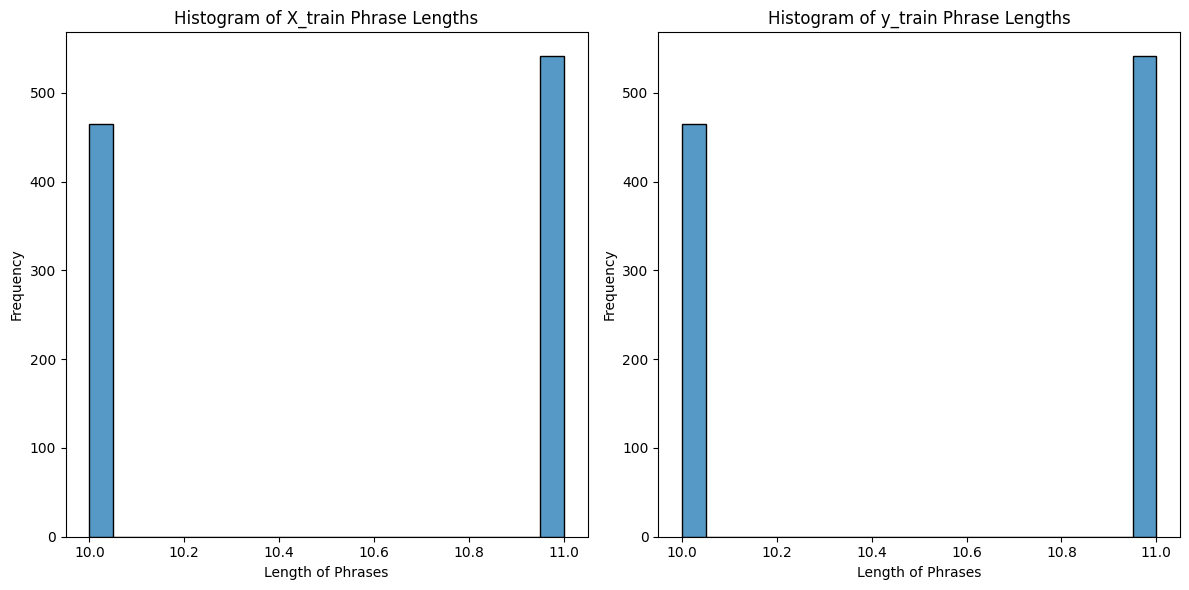

1006 Amanda baked cookies and will bring Jerry some tomorrow .
vocabulary size 2568


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
min_v = 10
max_v = 11
helper=Helper()
def load_x_y_train_plain():
    with open('corpus/train.json', 'r', encoding='utf-8') as f:
        try:
            dataset = json.load(f)  # Load the JSON data

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
    X_train = []
    y_train = []

    # #Loop through the list and process each dialogue and summary
    for data in dataset:
        dialogue = data['dialogue']  # Split dialogue into a list of lines
        summary = data['summary']

        X_train.append(dialogue)
        y_train.append(summary)
    return X_train, y_train


def split_x_y_train(X_train, y_train):
    X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
    y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]
    return X_train, y_train


# with open('data/vocabolary_full.pkl', 'rb') as f:
#     vocabulary=pickle.load(f)
def filter_train_data(X_train, y_train, to_eliminate):
    filtered_X_train = []
    filtered_y_train = []

    for x, y in zip(X_train, y_train):
        if not any(to_eliminate_str in x for to_eliminate_str in to_eliminate):
            filtered_X_train.append(x)
            filtered_y_train.append(y)

    return filtered_X_train, filtered_y_train


def create_complete_vocabulary(X_train, y_train):
    nlp_model = spacy.load('en_core_web_lg')
    nlp_model.disable_pipes(["parser", "ner"])
    complete_text_target = ' '.join(y_train)
    complete_text_origin = ' '.join(X_train)
    complete_text = complete_text_target + " [START] [PAD] [END] " + complete_text_origin

    vocabulary = helper.create_vocabulary(complete_text, "vocabolary_full", nlp_model)
    print("vocabulary size", len(vocabulary))
    return vocabulary


X_train, y_train = load_x_y_train_plain()
to_eliminate = [
    "[I hope I'm not coming off as rude - If I am, I'm sorry. I just thought it would be beneficial for the both of us...]",
    "[pulls back the curtain and checks out the window]",
    "[hopefully, masses of]"]
X_train, y_train = filter_train_data(X_train, y_train, to_eliminate)


sample = [i for i in range(0,len(y_train))]


X_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', x) for x in X_train]
y_train = [re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', y) for y in y_train]


X_train = [X_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]
y_train = [y_train[i] for i in sample if len(y_train[i]) <= max_v and len(y_train[i]) >= min_v]


# Calculate lengths of the tokenized phrases


def plot_lenghts(X_train,y_train):
    X_lengths = [len(x) for x in X_train]
    y_lengths = [len(y) for y in y_train]
    # Plot histograms
    plt.figure(figsize=(12, 6))

    # Histogram for X_train lengths
    plt.subplot(1, 2, 1)
    sns.histplot(X_lengths, bins=20, kde=False)
    plt.title('Histogram of X_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Histogram for y_train lengths
    plt.subplot(1, 2, 2)
    sns.histplot(y_lengths, bins=20, kde=False)
    plt.title('Histogram of y_train Phrase Lengths')
    plt.xlabel('Length of Phrases')
    plt.ylabel('Frequency')

    # Display the plots
    plt.tight_layout()
    plt.show()

X_train=[i[::-1] for i in y_train]
plot_lenghts(X_train,y_train)
 

X_train=[" ".join(x) for x in X_train]
y_train=[" ".join(y) for y in y_train]

print(len(y_train),y_train[0])

vocabulary=create_complete_vocabulary(X_train, y_train)

In [72]:
class Encoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase):
        self.batch_size=batch_size
        self.words_per_phrase=words_per_phrase
        self.num_heads=num_heads
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size)
        self.multihead_attention_encoder=multihead_attention(num_heads=2,embedding_size=embedding_size,batch_size=batch_size)
        self.residual_layer_1=residual_layer()
        self.residual_layer_2=residual_layer() 
        self.learning_rate=learning_rate
        self.helper=Helper()
     

    def forward(self,inputs_e):
        self.inputs_e=inputs_e 

        Ae=self.multihead_attention_encoder.forward_attention(inputs_e,inputs_e,inputs_e)
        
        Ect1=self.residual_layer_1.forward(Ae,inputs_e) 

        FLe2=self.fully_connected_block.forward(Ect1) 

        Ecout=self.residual_layer_2.forward(FLe2,Ect1)

        return Ecout


    def backpropagation(self,dLoss_Ecout,vocabulary,X_batch):
        
        dLoss_dFLe2 = dLoss_Ecout * self.normalization_layer_encoder_2.backpropagation()
        dLoss_Ect1_a = dLoss_dFLe2

        dLoss_dFLe1 = dLoss_dFLe2 @ self.linear_layer_econder_2.W.T

        dLoss_dWfl2e = cp.sum(cp.transpose(dLoss_dFLe2, (0, 2, 1)) @ self.linear_layer_econder_2.X,axis=0).T
 
        dLoss_dbfl2e = cp.sum(cp.sum(dLoss_dFLe2, axis=1),axis=0)
        

        dLoss_Ect1_b = self.relu_layer_encoder.backward_leaky(dLoss_dFLe1) @ cp.transpose(self.linear_layer_econder_1.W, (1, 0))

        dLoss_Ect1 = dLoss_Ect1_b + dLoss_Ect1_a
        
        dLoss_dWfl1e = cp.sum(cp.transpose(self.relu_layer_encoder.backward_leaky(dLoss_dFLe1), (0, 2, 1)) @ self.linear_layer_econder_1.X,axis=0).T
        
        dLoss_dbfl1e = cp.sum(cp.sum(self.relu_layer_encoder.backward_leaky(dLoss_dFLe1),axis=0),axis=0)

        #print(dLoss_dbfl1e.shape,linear_layer_econder_1.b.shape)
        dLoss_Ae = dLoss_Ect1 * self.normalization_layer_encoder_1.backpropagation()
        
        dLoss_inpute_a = dLoss_Ae

        dLoss_dQe=self.multihead_attention_encoder.diffQi(dLoss_Ae,self.inputs_e)

        dLoss_dKe=self.multihead_attention_encoder.diffKi(dLoss_Ae, self.inputs_e)

        dLoss_dVe=self.multihead_attention_encoder.diffVi(dLoss_Ae,self.inputs_e)
        
        dLoss_inpute_k=self.multihead_attention_encoder.diffKInput(dLoss_Ae,self.Ke.W)
        dLoss_inpute_q=self.multihead_attention_encoder.diffQInput(dLoss_Ae,self.Qe.W)
        dLoss_inpute_v=self.multihead_attention_encoder.diffVInput(dLoss_Ae,self.Ve.W)
        dLoss_input_e = dLoss_inpute_a + dLoss_inpute_k + dLoss_inpute_q + dLoss_inpute_v
        dLoss_dWemb_encoder = dLoss_input_e * self.inputs_e

        vocabulary=self.update_weights(dLoss_dWfl2e,
                                       dLoss_dbfl2e,
                                       dLoss_dWfl1e
                                       ,dLoss_dbfl1e,
                                       dLoss_dQe,
                                       dLoss_dKe,
                                       dLoss_dVe,dLoss_dWemb_encoder,vocabulary,X_batch)
        return vocabulary
    
    def update_weights(self,dLoss_dWfl2e,dLoss_dbfl2e,dLoss_dWfl1e,dLoss_dbfl1e,dLoss_dQe,dLoss_dKe,dLoss_dVe,dLoss_dWemb_encoder,vocabulary,X_batch):
        self.linear_layer_econder_2.update_weights(dLoss_dWfl2e,dLoss_dbfl2e,self.learning_rate)
        self.linear_layer_econder_1.update_weights(dLoss_dWfl1e,dLoss_dbfl1e,self.learning_rate)

        self.Qe.update_weights_only(dLoss_dQe,self.learning_rate)
        self.Ke.update_weights_only(dLoss_dKe,self.learning_rate)
        self.Ve.update_weights_only(dLoss_dVe,self.learning_rate)
        self.inputs_e=self.inputs_e-self.learning_rate*dLoss_dWemb_encoder
        vocabulary=self.helper.update_wembedding_encoder(X_batch,self.inputs_e,vocabulary,self.words_per_phrase)
        return vocabulary
    

class Decoder:
    def __init__(self,embedding_size,num_heads,linear_layer_size,learning_rate,batch_size,words_per_phrase):
        self.words_per_phrase=words_per_phrase
        self.batch_size=batch_size
        self.num_heads=num_heads 
        self.linear_layer_size=linear_layer_size
        self.embedding_size=embedding_size  
        self.multihead_cross_attention=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size)
        self.multihead_attention_decoder=multihead_attention(num_heads=num_heads,embedding_size=embedding_size,batch_size=batch_size) 
        self.learning_rate=learning_rate
        self.helper=Helper() 
        self.residual_layer_1=residual_layer()
        self.residual_layer_2=residual_layer() 
        self.residual_layer_3=residual_layer() 
        self.fully_connected_block=fully_connected_block(self.embedding_size,linear_layer_size)

    def forward(self,inputs_decoder,Ecout,step):
        self.inputs_decoder=inputs_decoder 
        
        A_mask=self.multihead_attention_decoder.forward_masked_attention(inputs_decoder,inputs_decoder,inputs_decoder,mask_size=inputs_decoder.shape[1])
    
        #Xd=self.inputs_decoder+A_mask

        Dt1=self.residual_layer_1.forward(self.inputs_decoder,A_mask)


        Acr=self.multihead_cross_attention.forward_attention(Dt1,Ecout,Ecout)
         
        #Res=Acr+Dt1
 
        Dt2=self.residual_layer_2.forward(Acr,Dt1)
 
        FLd2=self.fully_connected_block.forward(Dt2)
        
        
        #Xd2=FLd2+Dt2 
        
        Dout=self.residual_layer_3.forward(FLd2,Dt2)
        #print(Dout)
        Dout = Dout[:, step, :]
        #print(Dout)
        return Dout


    def backpropagation(self,dLoss_dDout,vocabulary,y_batch):
        
        
        dLoss_dFLd2=cp.expand_dims(dLoss_dDout,axis=1)*self.normalization_layer_decoder_3.backpropagation()
        dLoss_dDt2_a=dLoss_dFLd2
        
            
        dLoss_dFLd1 = dLoss_dFLd2 @ self.linear_layer_decoder_2.W.T

        
        dLoss_dWfl2d = cp.sum(cp.transpose(dLoss_dFLd2, (0, 2, 1)) @ self.linear_layer_decoder_2.X, axis=0).T
        dLoss_dbfl2d = cp.sum(cp.sum(dLoss_dFLd2, axis=0), axis=0)
        
        DLoss_dDt2_b =self.relu_layer_decoder.backward_leaky(dLoss_dFLd1) @ cp.transpose(self.linear_layer_decoder_1.W, (1, 0))
        DLoss_dDt2 = DLoss_dDt2_b + dLoss_dDt2_a 
         
        dLoss_dWfl1d = cp.sum(cp.transpose(self.relu_layer_decoder.backward_leaky(dLoss_dFLd1), (0, 2, 1)) @ self.linear_layer_decoder_1.X, axis=0).T
        dLoss_dbfl1d = cp.sum(cp.sum(self.relu_layer_decoder.backward_leaky(dLoss_dFLd1), axis=0), axis=0)
        # 
        dLoss_dAcr = DLoss_dDt2 * self.normalization_layer_decoder_2.backpropagation()
        dLoss_dDt1_a = dLoss_dAcr
 
        dLoss_dQc = self.multihead_cross_attention.diffQi(dLoss_dAcr,self.Qc.X)
         
        dLoss_dKc=self.multihead_cross_attention.diffKi(dLoss_dAcr,self.Kc.X)
         
        dLoss_dVc=self.multihead_cross_attention.diffVi(dLoss_dAcr,self.Vc.X)
         
        dAttention_weights_cross = self.multihead_cross_attention.Attention_weights * (1 - self.multihead_cross_attention.Attention_weights)

        dLoss_dDt1_b= dLoss_dAcr * self.helper.redimension(dAttention_weights_cross @ (self.multihead_cross_attention.K * self.multihead_cross_attention.V / cp.sqrt(embedding_size))) @ self.Qc.W

        dLoss_dDt1 =  dLoss_dDt1_b+ dLoss_dDt1_a
           
        dLoss_Amask = dLoss_dDt1 * self.normalization_layer_decoder_1.backpropagation() 

        dLoss_inputd_a = dLoss_Amask

        dLoss_Kd=self.multihead_attention_decoder.diffKi(dLoss_Amask,self.inputs_decoder)
        # 
        dLoss_Qd =self.multihead_attention_decoder.diffQi(dLoss_Amask,self.inputs_decoder)
        #
        dLoss_Vd =self.multihead_attention_decoder.diffVi(dLoss_Amask,self.inputs_decoder)
        #
        dLoss_inputd_k=self.multihead_attention_decoder.diffKInput(dLoss_Amask,self.Kd.W)
        dLoss_inputd_q=self.multihead_attention_decoder.diffQInput(dLoss_Amask,self.Qd.W)
        dLoss_inputd_v=self.multihead_attention_decoder.diffVInput(dLoss_Amask,self.Vd.W)
        dLoss_input_d = dLoss_inputd_a + dLoss_inputd_k + dLoss_inputd_q + dLoss_inputd_v
        dLoss_dWemb_decoder= dLoss_input_d * self.inputs_decoder

        vocabulary=self.update_weights(dLoss_dWfl2d,
                                        dLoss_dbfl2d,
                                        dLoss_dWfl1d,
                                        dLoss_dbfl1d,
                                        dLoss_dQc,
                                        dLoss_dKc,
                                        dLoss_dVc,
                                        dLoss_Kd,
                                        dLoss_Qd,
                                        dLoss_Vd,
                                        dLoss_dWemb_decoder,
                                        vocabulary,
                                        y_batch)
        return vocabulary,dLoss_dAcr
    
    def update_weights(self,dLoss_dWfl2d,
                       dLoss_dbfl2d,
                       dLoss_dWfl1d,
                       dLoss_dbfl1d,
                       dLoss_dQc,
                       dLoss_dKc,
                       dLoss_dVc,
                       dLoss_Kd,
                       dLoss_Qd,
                       dLoss_Vd,
                       dLoss_dWemb_decoder,
                       vocabulary,
                       y_batch):
        self.linear_layer_decoder_2.update_weights(dLoss_dWfl2d,dLoss_dbfl2d,self.learning_rate)
        self.linear_layer_decoder_1.update_weights(dLoss_dWfl1d,dLoss_dbfl1d,self.learning_rate)
        self.Qc.update_weights_only(dLoss_dQc,self.learning_rate)
        self.Kc.update_weights_only(dLoss_dKc,self.learning_rate)
        self.Vc.update_weights_only(dLoss_dVc,self.learning_rate)
        self.Kd.update_weights_only(dLoss_Kd,self.learning_rate)
        self.Qd.update_weights_only(dLoss_Qd,self.learning_rate)
        self.Vd.update_weights_only(dLoss_Vd,self.learning_rate)
        self.inputs_decoder=self.inputs_decoder-self.learning_rate*dLoss_dWemb_decoder
        vocabulary=self.helper.update_wembedding_decoder(y_batch,self.inputs_decoder,self.words_per_phrase,vocabulary) 
        return vocabulary
embedding_size=300
fl1_size=2048
learning_rate=0.0001
batch_size=64
num_heads=10
dropout_rate=0.1


In [73]:
import traceback
# inputs_e=cp.random.rand(4,11,300)
# inputs_d=cp.random.rand(11,4,11,300)
# target_i=cp.array([1, 2,3,4])
TransformerEncoder=Encoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)
TransformerDecoder=Decoder(embedding_size,num_heads,fl1_size,learning_rate,batch_size=batch_size,words_per_phrase=max_v)
words_per_phrase = num_phrases= max_v
output_linear_layer=linear_layer(embedding_size,len(vocabulary),out=True)  
num_batches_per_epoch = len(X_train) // batch_size
num_epochs=550
tot_loss_epoch=0

for epoch in range(num_epochs):
    print("Loss",tot_loss_epoch/num_batches_per_epoch)
    tot_loss_epoch=0
    total_accuracy_epoch=0
    
    for i in tqdm(range(0,num_batches_per_epoch),desc=f"Epoch {epoch + 1}/{num_epochs}"):
        try: 
            start = i * batch_size
            end = start + batch_size 
            X_batch = X_train[start:end]
            y_batch = y_train[start:end] 
            #print(X_batch)
            inputs_e=helper.create_input_encoder(X_batch,vocabulary,words_per_phrase,embedding_size) 
            inputs_d=helper.create_decoder_input(y_batch,embedding_size,words_per_phrase,vocabulary) 
            Ecout=TransformerEncoder.forward(inputs_e)
            
            #print("inputs_e.shape",inputs_e.shape)
            #print("inputs_d.shape",inputs_d.shape,"inputs_e.shape",inputs_e.shape) 
 
            target_d=helper.pad_sequences(y_batch,lenght=words_per_phrase,target_type="target") 
            target_d=[re.findall(r'\[.*?\]|\w+|[^\w\s]|\n', xx) for xx in target_d] 
            tot_loss=0
            totdLoss_dAcr=0
            counter_correct=0
            total_accuracy_batch=0
            for step in range(0, inputs_d.shape[0]):
                inputs_decoder = inputs_d[step]
                #target_i = cp.array([helper.get_one_hot(x[step], vocabulary) for x in target_d])
                target_i=cp.array([vocabulary[x[step]][1] for x in target_d])
                Dout = TransformerDecoder.forward(inputs_decoder, Ecout, step)
                Zout = output_linear_layer.forward(Dout)
                SigmaZout = helper.softmax(Zout)
                
                # Calculate loss
                #Loss = helper.cross_entropy_loss(SigmaZout, target_i)
                #dLoss_dZout = SigmaZout - target_i 
                Loss = helper.sparse_categorical_crossentropy(SigmaZout, target_i)  
                dLoss_dZout = SigmaZout.copy()  # Create a copy of the softmax output 
                dLoss_dZout[np.arange(target_i.shape[0]), target_i] -= 1 

                #helper.log_sparse_entropy(SigmaZout, target_i,y_batch,step)
                #print(Loss)
                # Backpropagation
                
                # clip_value = 1.0
                # dLoss_dZout = cp.clip(dLoss_dZout, -clip_value, clip_value)
                
                dLoss_dDout = dLoss_dZout @ output_linear_layer.W.T
                
                # Backpropagation through decoder
                # vocabulary, dLoss_dAcr = TransformerDecoder.backpropagation(dLoss_dDout, vocabulary, y_batch)
                # tot_loss+=Loss 
                # batch_acc=helper.accruacy_sparse_entropy(SigmaZout,target_i)
                # total_accuracy_batch+=batch_acc
                # if batch_acc>0:
                #     helper.print_target_vs_prediction_sparce_loss(SigmaZout,target_i)
            #print("total_accuracy_batch",total_accuracy_batch)
            
            # dLoss_dAcr = cp.clip(dLoss_dAcr, -clip_value, clip_value)
            # dLoss_Ecout=cp.clip(dLoss_dAcr, -clip_value, clip_value)
            # After decoder, calculate gradients for encoder
            # dLoss_Ecout_k = TransformerDecoder.multihead_cross_attention.diffKInput(dLoss_dAcr, TransformerDecoder.Kc.W)
            # dLoss_Ecout_v = TransformerDecoder.multihead_cross_attention.diffVInput(dLoss_dAcr, TransformerDecoder.Vc.W)
            # dLoss_Ecout = dLoss_Ecout_k + dLoss_Ecout_v
            
            #     # Backpropagation through encoder
            # vocabulary = TransformerEncoder.backpropagation(dLoss_Ecout, vocabulary, X_batch)
            
            # tot_loss_epoch+=tot_loss/inputs_d.shape[0] 
            # total_accuracy_epoch+=total_accuracy_batch
 
        except Exception as e:
            print(e)
            traceback.print_exc()  
    print("total_accuracy_epoch",total_accuracy_epoch)

Loss 0.0


Epoch 1/550:   0%|          | 0/15 [00:00<?, ?it/s]

Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)


Epoch 1/550:   0%|          | 0/15 [00:01<?, ?it/s]

Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)
Output encoder shape concat: (64, 11, 300)


KeyboardInterrupt: 